In [23]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
from risk_mgmt import simulation
import sys
sys.path.append('/Users/ansel_li/Fintech545/public/')

In [24]:
def black_scholes(S, X, r, q, t, sigma, option):
    # S = current stock price
    # X = option strike price
    # t = time to maturity
    # r = risk-free rate
    # q = continuously compounding dividend yield
    # sigma = volatility
    
    d1 = (np.log(S / X) + (r - q + (sigma ** 2) / 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    if option.lower() == "call":
        P = S * np.exp(-q * t) * stats.norm.cdf(d1) - X * np.exp(-r * t) * stats.norm.cdf(d2)
    elif option.lower() == 'put':
        P = X * np.exp(-r * t) * stats.norm.cdf(-d2) - S * np.exp(-q * t) * stats.norm.cdf(-d1)
    else:
        raise ValueError("Choose option type from 'put' and 'call'.")
    
    return P


In [25]:
# Calendar days
cd = 14

#Time to maturity (T)
t = cd/365

# Current price (S)
S = 165

# Strike price (X)
X_C = 150
X_P = 180

# Risk free rate
rf = 0.0425

# Dividend (Coupon)
q = 0.0053


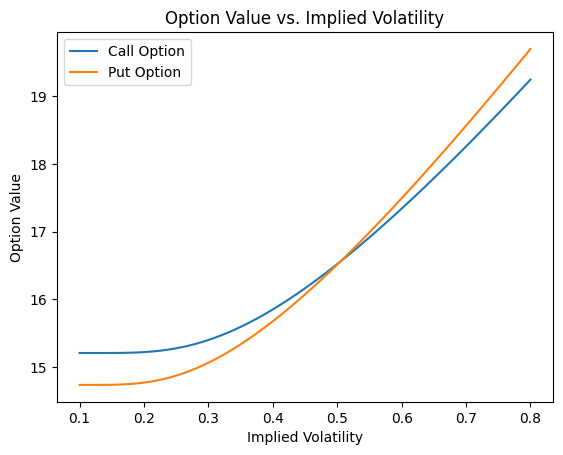

In [26]:
implied_volatilities = np.linspace(0.1, 0.8, 100)
call_values = []
put_values = []

for sigma in implied_volatilities:
    call = black_scholes(S, X_C, rf, q, t, sigma,option='call')
    put = black_scholes(S, X_P, rf, q, t, sigma,option='put')
    call_values.append(call)
    put_values.append(put)

plt.plot(implied_volatilities, call_values, label="Call Option")
plt.plot(implied_volatilities, put_values, label="Put Option")
plt.xlabel("Implied Volatility")
plt.ylabel("Option Value")
plt.legend()
plt.title("Option Value vs. Implied Volatility")
plt.show()


We can see when vol start from 0.1, the option value of Call is greater than that of Put, as implied volatility increases, put option value becomes greater than call option value

# Problem2

In [27]:
def implied_volatility(S, X, r, q, t, market_price, option_type='call', initial_guess=0.5, max_iter=100, tol=1e-8):
    sigma = initial_guess

    for _ in range(max_iter):
        if option_type.lower() == 'call':
            option_price = black_scholes(S, X, r, q, t, sigma, 'call')
        elif option_type.lower() == 'put':
            option_price = black_scholes(S, X, r, q, t, sigma, 'put')
        else:
            raise KeyError('InValid option type, choose "put" or "call".')

        d1 = (np.log(S / X) + (r - q + (sigma ** 2) / 2) * t) / (sigma * np.sqrt(t))
        vega = S * np.exp(-q * t) * stats.norm.pdf(d1) * np.sqrt(t)

        diff = option_price - market_price

        if abs(diff) < tol:
            return sigma

        sigma = sigma - diff / vega

    return None  # implied volatility not found within the given tolerance


In [28]:
data = pd.read_csv('AAPL_Options.csv')
data['Expiration'] = pd.to_datetime(data['Expiration'])
S = 151.03
today = pd.to_datetime('2023-03-03')
data['T'] = (data['Expiration'] - today).dt.days / 365

data['Implied_Volatility'] = data.apply(
    lambda row: implied_volatility(S, row['Strike'], rf, q, row['T'], row['Last Price'], row['Type']),
    axis=1
)
data.head()

,Stock,Expiration,Type,Strike,Last Price,T,Implied_Volatility
0,AAPL,2023-04-21,Call,125,27.300,0.134247,0.374597
1,AAPL,2023-04-21,Call,130,22.575,0.134247,0.342351
2,AAPL,2023-04-21,Call,135,17.750,0.134247,0.292522
3,AAPL,2023-04-21,Call,140,13.850,0.134247,0.299358
4,AAPL,2023-04-21,Call,145,9.975,0.134247,0.278743


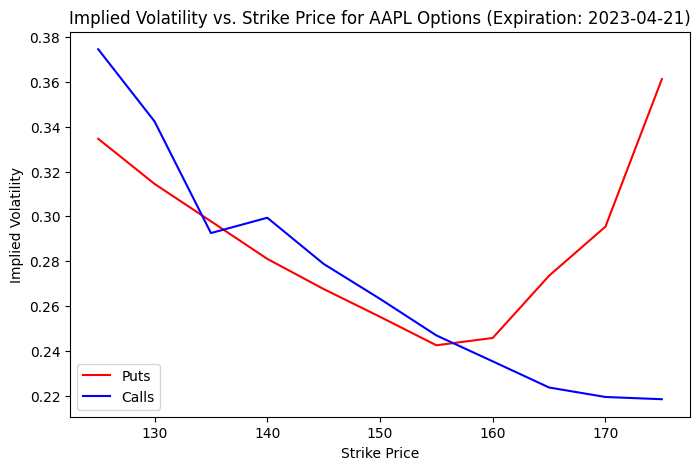

In [29]:
import matplotlib.pyplot as plt

# Separate Puts and Calls data
puts = data[data['Type'] == 'Put']
calls = data[data['Type'] == 'Call']

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(puts['Strike'], puts['Implied_Volatility'], 'r-', label='Puts')
plt.plot(calls['Strike'], calls['Implied_Volatility'], 'b-', label='Calls')

# Set labels and title
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Strike Price for AAPL Options (Expiration: %s)'%(data['Expiration'].dt.date[0]))
plt.legend()

# Show the plot
plt.show()


# Problem 3

In [30]:
# risk free rate and dividend
rf = 0.0425
q = 0.0053
S = 151.03
port = pd.read_csv('problem3.csv')
current_date = pd.to_datetime('2023-03-03')
port['ExpirationDate'] = pd.to_datetime(port['ExpirationDate'])
port['T'] = (port['ExpirationDate'] - current_date).dt.days / 365

port['Implied_Volatility'] = port.apply(
    lambda row: implied_volatility(S, row['Strike'], rf, q, row['T'], row['CurrentPrice'], row['OptionType'])
    if row['Type'] == 'Option' else np.nan,
    axis=1
)
port.head()

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice,T,Implied_Volatility
0,Straddle,Option,AAPL,1,Call,2023-04-21,150.0,6.80,0.134247,0.267740
1,Straddle,Option,AAPL,1,Put,2023-04-21,150.0,4.85,0.134247,0.259735
2,SynLong,Option,AAPL,1,Call,2023-04-21,150.0,6.80,0.134247,0.267740
3,SynLong,Option,AAPL,-1,Put,2023-04-21,150.0,4.85,0.134247,0.259735
4,CallSpread,Option,AAPL,1,Call,2023-04-21,150.0,6.80,0.134247,0.267740


In [31]:
def portfolio_value(portfolio, underlying_range, r, q, current_date, day_ahead = 0):
    values = []

    for underlying in underlying_range:
        total_value = 0

        for _, row in portfolio.iterrows():
            holding = row['Holding']

            if row['Type'] == 'Stock':
                total_value += holding * underlying
            elif row['Type'] == 'Option':
                T = ((row['ExpirationDate'] - current_date) / pd.Timedelta(1, 'D') - day_ahead) / 365
                option_value = black_scholes(underlying, row['Strike'], r, q, T, row['Implied_Volatility'], row['OptionType'])
                total_value += holding * option_value
        
        values.append(total_value)

    return values

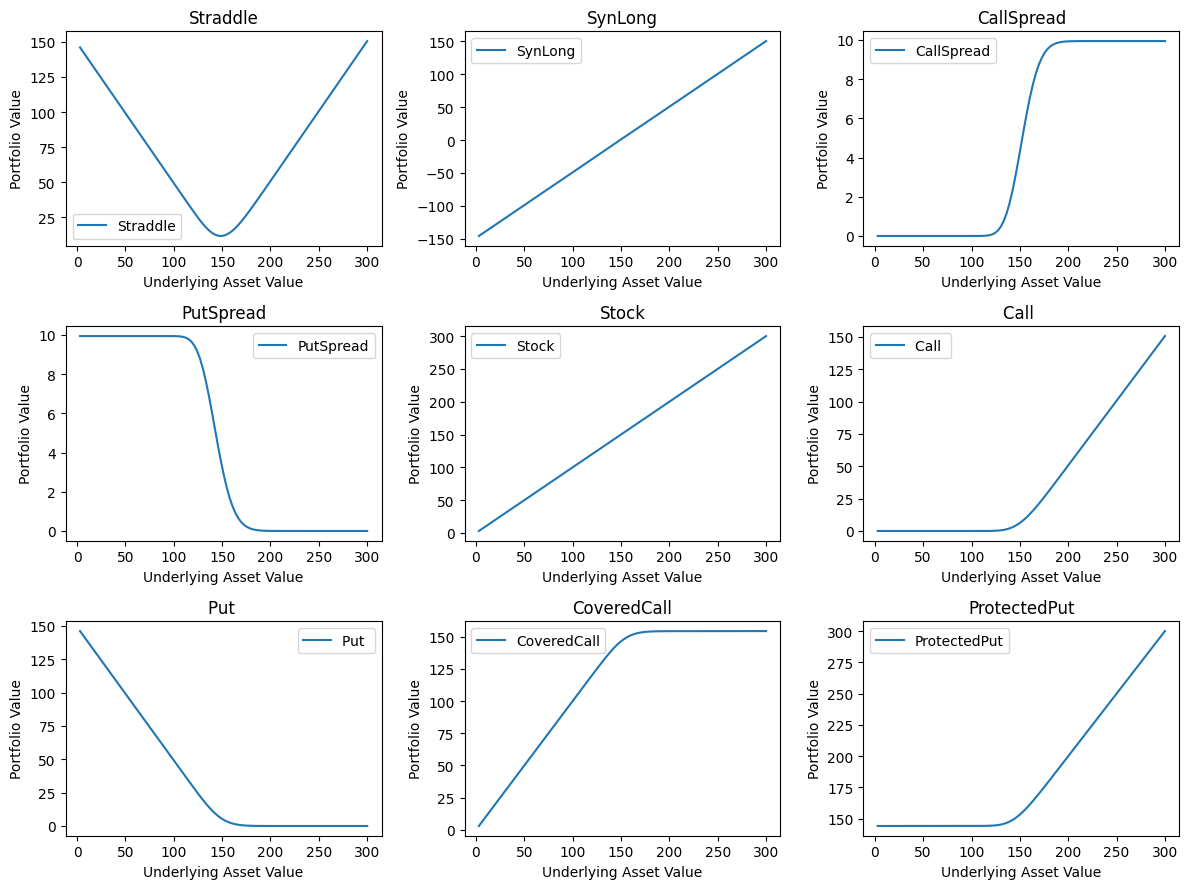

In [32]:
# Get a list of unique portfolio names
portfolios = port['Portfolio'].unique()

# Define the range of underlying asset values
underlying_range = np.linspace(0, 300, num=100)[1:]


# Define the number of rows and columns in the grid
nrows = 3
ncols = 3

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

# Loop through the portfolios and add a plot to the grid
for i, portfolio_name in enumerate(portfolios):
    # Calculate the row and column index of the current subplot
    row = i // ncols
    col = i % ncols

    # Get the current axis
    ax = axes[row, col]

    # Calculate the portfolio values
    portfolio_data = port[port['Portfolio'] == portfolio_name]
    values = portfolio_value(portfolio_data, underlying_range, rf, q, current_date)
    
    # Plot the portfolio values on the current axis
    ax.plot(underlying_range, values, label=portfolio_name)
    ax.set_xlabel('Underlying Asset Value')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'{portfolio_name}')
    ax.legend()

# Adjust the layout of the subplots and show the plot
plt.tight_layout()
plt.show()

In [33]:

# Read CSV files
prices = pd.read_csv('DailyPrices.csv')


# demean log return of aapl
return_aapl = simulation.log_returns(prices['AAPL'])
m_return = np.mean(return_aapl)
return_aapl = return_aapl - m_return
# Fit the AR(1) model
ar1_model = ARIMA(return_aapl, order=(1, 0, 0))
ar1_results = ar1_model.fit()


In [34]:
n_forecast = 10
sim = 1000
phi = ar1_results.params[1]
beta = ar1_results.params[0]
sigma = ar1_results.resid.std()
# Generate the simulated returns
simulated_returns = np.zeros((n_forecast,sim))
for j in range(sim):
    simulated_returns[0,j]= beta + phi * return_aapl[-1] + sigma * norm.rvs()
    for i in range(n_forecast-1):
        simulated_returns[i+1,j] = beta + phi * simulated_returns[i,j] + sigma * norm.rvs()

initial_price = 151.03

# Calculate the price series
price_series = pd.DataFrame(initial_price * np.exp(simulated_returns.cumsum(axis=0)))

simulation_price = price_series.loc[9:].values[0]


In [35]:
price_series

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,153.396975,152.900723,151.271379,151.306127,154.065910,147.538643,149.084030,154.249703,152.058222,146.296730,...,152.979075,148.508386,152.075492,151.965689,155.940075,156.312464,148.593249,151.530265,155.217316,151.386719
1,156.428045,146.931477,152.220637,153.701714,153.361641,146.963846,150.618191,155.625430,147.017758,146.281331,...,156.827807,146.822874,153.496309,152.270043,163.057657,158.023159,145.518744,150.091574,156.471025,152.056029
2,153.385066,142.576546,153.063817,150.372595,155.175082,155.418640,151.563187,157.263926,149.280236,150.490171,...,162.058681,145.234213,150.648076,151.224771,159.480432,160.653161,143.905430,147.997560,154.179835,150.692047
3,153.605300,145.214942,150.844804,155.658000,162.969309,157.016279,148.530094,152.235302,150.495391,150.564727,...,172.620321,142.503270,149.738357,153.139669,158.652019,161.764111,141.131828,150.968575,151.314348,156.209818
4,150.104059,145.037068,151.448396,154.330762,162.258523,154.540465,145.249625,153.000515,154.345429,149.067037,...,171.310539,141.327018,148.810188,153.040409,158.966581,167.365748,140.415113,156.535579,149.552945,159.458572
5,153.616701,141.094658,146.518948,154.993465,163.963772,154.777100,145.282225,153.151195,148.823179,153.711608,...,173.848321,143.544133,151.403000,151.778265,156.844477,162.030893,136.264764,154.474272,146.133853,167.314970
6,159.951934,145.302817,146.262765,153.849926,164.265193,158.225123,142.059813,148.469488,149.803818,155.760412,...,173.159507,146.001518,151.995121,147.524375,157.250213,165.941099,137.874623,154.355521,146.900268,168.115058
7,159.400626,141.695404,144.312505,154.512261,155.097802,162.198796,145.302825,145.995772,157.833207,152.633018,...,180.810787,142.867958,151.773882,147.561512,156.435068,169.349530,142.373278,155.461684,145.857684,172.533085
8,159.962983,144.322970,147.454715,152.394364,156.358778,161.092881,144.489794,148.632196,157.983619,148.476788,...,179.619271,146.901148,157.469072,149.320311,160.005590,172.378970,143.488440,153.369443,143.241867,164.631134
9,155.837483,148.157129,147.178684,154.787117,154.323469,162.297699,141.775193,148.303747,162.349261,149.625335,...,183.523441,144.657101,156.761410,151.285186,163.594382,172.417754,138.205675,151.513030,141.471246,167.403787


In [36]:
from risk_mgmt import VaR

In [37]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=portfolios, index=['Mean', 'VaR', 'ES'])

# Iterate through each portfolio and calculate the Mean, VaR, and ES
for portname in portfolios:
    portfolio_data = port[port['Portfolio'] == portname]
    simulate_portfolio_values = pd.DataFrame(portfolio_value(portfolio_data, simulation_price, rf, q, current_date, day_ahead=10))
    current_portfolio_values = pd.DataFrame(portfolio_value(portfolio_data, [initial_price], rf, q, current_date))

    # Calculate the difference between simulated and current portfolio values
    current_portfolio_value = current_portfolio_values.values[0][0]
    diff_portfolio_values = simulate_portfolio_values.apply(lambda x: x - current_portfolio_value)

    #print(diff_portfolio_values.values[0])
    # Calculate the Mean, VaR, and ES for the difference
    Mean = diff_portfolio_values.mean().values[0]

    var = VaR.calculate_var(diff_portfolio_values.values)
    es = VaR.calculate_es(diff_portfolio_values.values)

    # Add the results to the DataFrame
    results_df.at['Mean', portname] = Mean
    results_df.at['VaR', portname] = var
    results_df.at['ES', portname] = es

# Display the results
results_df.T

,Mean,VaR,ES
Straddle,1.681096,1.380783,1.387824
SynLong,0.215258,16.437672,20.414538
CallSpread,-0.039387,3.912805,4.219456
PutSpread,0.26704,2.629686,2.819268
Stock,0.419859,16.193816,20.14699
Call,0.948177,6.063505,6.404707
Put,0.732919,4.366393,4.611642
CoveredCall,-0.632114,12.368091,16.202312
ProtectedPut,1.051666,8.117699,8.761803
